# TensorBoard

## Dependencies

Note: the following dependencies were **not included** in the project's requirements file:
* tensorflow
* tensorboard
* torch

In [1]:
# Load in the used dependencies
import os
import numpy as np
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Data

### Hyperparameters

In [2]:
LOG_DIR = './population_backup/storage/experiment6/'
topology_id = 2
overwrite = True
rm_duplicates = False  # Remove all samples with at least 'dup_columns' duplicate values
dup_columns = None  # Number of duplicated columns a single sample has before removal
perfect_score = True  # Filter to only contain samples that solve the problem

### Fetch

In [3]:
# Setup the header
head = ['fitness']
if topology_id in [1, 2, 3]:  # GRU populations
    head += ['bias_r', 'bias_z', 'bias_h',
             'weight_xr', 'weight_xz', 'weight_xh',
             'weight_hr', 'weight_hz', 'weight_hh']
elif topology_id in [4]:  # SRU populations
    head += ['bias_h', 'weight_xh', 'weight_hh']
else:
    raise Exception(f"Topology ID '{topology_id}' not supported!")

if topology_id in [1]:
    head += ['conn1', 'conn2']
elif topology_id in [2]:
    head += ['bias_rw', 'conn2']
elif topology_id in [3, 4]:
    head += ['bias_rw', 'conn0', 'conn1', 'conn2']
else:
    raise Exception(f"Topology ID '{topology_id}' not supported!")

In [4]:
# Check if tsv files already exist
raw_path = os.path.join(LOG_DIR, f'topology_{topology_id}/data/data.csv')
data_path = os.path.join(LOG_DIR, f'topology_{topology_id}/data/data.tsv')
meta_path = os.path.join(LOG_DIR, f'topology_{topology_id}/data/meta.tsv')

# Load in the data (without header)
if not overwrite and os.path.exists(data_path):
    data = np.genfromtxt(data_path, delimiter='\t')
    meta = np.genfromtxt(meta_path, delimiter='\t')
else:
    raw = np.genfromtxt(raw_path, delimiter=',')[1:]
    data = raw[:,:-1]
    meta = raw[:,-1]
    np.savetxt(data_path, data, delimiter='\t')
    np.savetxt(meta_path, meta, delimiter='\t')

# Print shape:
print(f"Data shape: {data.shape}")
print(f"Meta shape: {meta.shape}")

Data shape: (100052, 11)
Meta shape: (100052,)


In [5]:
# Transform to pandas dataframe (easier to manipulate)
data_pd = pd.DataFrame(data, columns=head[1:])
meta_pd = pd.DataFrame(meta, columns=head[:1])

In [6]:
data_pd.head()

,bias_r,bias_z,bias_h,weight_xr,weight_xz,weight_xh,weight_hr,weight_hz,weight_hh,bias_rw,conn2
0,-1.367109,2.090253,-0.449092,0.153726,0.932041,2.089773,3.355539,2.827017,-0.533423,1.80268,-3.405215
1,-1.936972,2.090253,-0.449092,-0.118474,0.708019,2.089773,3.536528,2.827017,-0.533423,1.80268,-3.405215
2,-1.367109,2.090253,-0.449092,0.153726,0.932041,2.089773,3.515875,2.827017,-0.533423,1.80268,-3.405215
3,-1.635319,2.090253,-0.449092,-0.118474,0.708019,2.089773,3.216672,2.827017,-0.533423,1.80268,-3.405215
4,-1.635319,2.090253,-0.449092,-0.118474,0.708019,2.089773,3.536528,2.827017,-0.533423,1.80268,-3.405215


In [7]:
meta_pd.head()

,fitness
0,0.888889
1,0.944444
2,0.888889
3,0.944444
4,0.944444


### Filter the data

In [8]:
# Filter out the complete duplicates
indices = data_pd.duplicated()
data_pd = data_pd[~indices.values]
meta_pd = meta_pd[~indices.values]
print(f"Data shape: {data_pd.shape}")
print(f"Meta shape: {meta_pd.shape}")

Data shape: (74885, 11)
Meta shape: (74885, 1)


In [9]:
# For example, if you want to see only fitnesses of 1 (perfect score).
if perfect_score:
    indices = meta_pd == 1
    data_pd = data_pd[indices.values]
    meta_pd = meta_pd[indices.values]
    print(f"Data shape: {data_pd.shape}")
    print(f"Meta shape: {meta_pd.shape}")

Data shape: (28037, 11)
Meta shape: (28037, 1)


In [10]:
# Filter out all the samples that have at least one duplicate value (in each of its columns)
if rm_duplicates:
    indices = (meta_pd<0).astype(int).values.flatten()  # Little hack
    for h in head[1:]:
        indices += data_pd.duplicated(subset=h).astype(int).values

    # Remove all that exceed the set threshold
    data_pd = data_pd[indices < dup_columns]
    meta_pd = meta_pd[indices < dup_columns]
    print(f"Dropping duplicates that occur in {dup_columns} columns or more")
    print(f" > Data shape: {data_pd.shape}")
    print(f" > Meta shape: {meta_pd.shape}")

In [11]:
data_pd

,bias_r,bias_z,bias_h,weight_xr,weight_xz,weight_xh,weight_hr,weight_hz,weight_hh,bias_rw,conn2
45,-1.367109,2.090253,-0.449092,0.280700,0.932041,2.089773,3.355539,2.827017,-1.769054,1.802680,-3.518890
53,-1.367109,2.090253,-0.449092,0.509054,0.997340,2.089773,3.484835,3.348872,-0.450934,1.802680,-3.405215
70,-1.239318,1.836362,-0.448091,0.163939,0.949667,2.116934,3.186708,0.212072,-1.108011,1.802680,-3.775642
71,-1.239318,1.836362,-0.448091,0.070387,0.949667,2.116934,3.186708,0.212072,-1.108011,1.802680,-3.775642
75,-1.239318,1.836362,-0.448091,0.070387,0.949667,2.148954,2.809227,0.226134,-1.108011,1.802680,-3.775642
...,...,...,...,...,...,...,...,...,...,...,...
99980,0.562204,1.754302,0.033570,1.414668,-1.524409,2.527452,-3.328351,0.938839,0.725119,0.107884,-3.409254
99982,0.562204,1.754302,0.033570,1.402816,-1.524409,2.527452,-3.451696,0.938839,0.725119,0.107884,-3.409254
99983,0.595126,1.754302,0.033570,1.414668,-1.524409,2.527452,-3.451696,0.938839,0.725119,0.107884,-3.409254
99984,0.562204,1.754302,0.033570,1.414668,-1.524409,2.527452,-3.451696,0.938839,0.783780,0.107884,-3.409254


### Visualize the data

Remark: Symmetry in data clearly by conn1 (this is the connection between GRU node and output of the global network) 

In [21]:
def adapt_and_show(data, indices=None):
    data_temp = data
    if indices is not None: data_temp = data_temp[indices.values]
    print(f"Size: {data_temp.shape}")
    plt.figure(figsize=(15,5))
    for i, h in enumerate(head[1:]):
        plt.subplot(int(len(head)/6+1),6,i+1)
        sns.violinplot(data_temp[h])
        plt.title(h)
        if 'bias' in h:
            plt.xlim(-3,3)
        else:
            plt.xlim(-6,6)
        plt.yticks([])
    plt.tight_layout()
    plt.show()
    plt.close()

Size: (28037, 11)


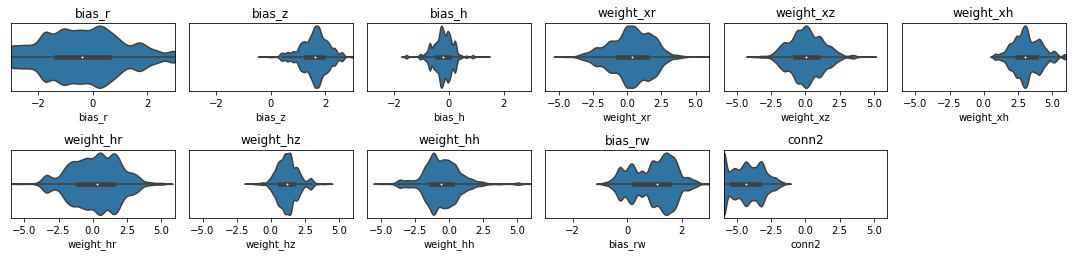

In [22]:
# indices = (data_pd['conn1'] > 0) & (data_pd['conn0'] > 0)
indices = None
adapt_and_show(data_pd, indices)

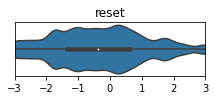

In [51]:
h = 'bias_r'
t = 'reset'
plt.figure(figsize=(3,1.5))
sns.violinplot(data_pd[h])
plt.title(t)
if 'bias' in h:
    plt.xlim(-3,3)
else:
    plt.xlim(-6,6)
plt.yticks([])
plt.xlabel('')
plt.tight_layout()
plt.savefig(f"delete_me/{h}.png", bbox_inches='tight', pad_inches=0.02)
plt.show()
plt.close()

### Format

Create labels for visualisation.

In [19]:
# Create better labels
meta_str = []
for d, m in zip(data_pd.values, meta_pd.values):
    s = [str(round(m[0], 2))]
    s += [str(round(x, 5)) for x in d]
    meta_str.append(s)   

# Example
print(f"Data example: \n> {data_pd.values[0]}")
print(f"Label example: \n> {meta_str[0]}")
print(f"For header: \n> {head}")

Data example: 
> [-1.36710907  2.09025344 -0.44909209  0.28070022  0.93204121  2.08977346
  3.35553888  2.82701727 -1.76905367  1.80268021 -3.51888981]
Label example: 
> ['1.0', '-1.36711', '2.09025', '-0.44909', '0.2807', '0.93204', '2.08977', '3.35554', '2.82702', '-1.76905', '1.80268', '-3.51889']
For header: 
> ['fitness', 'bias_r', 'bias_z', 'bias_h', 'weight_xr', 'weight_xz', 'weight_xh', 'weight_hr', 'weight_hz', 'weight_hh', 'bias_rw', 'conn2']


## Magic

Folder in which data is stored is "runs/topology_1" (always keep "runs"). Change this is you want to compare several configurations.

In [20]:
# Fire up the TensorBoard
writer = SummaryWriter(log_dir=f"runs/topology_{topology_id}")  # Overwrites if already exists
writer.add_embedding(data_pd.to_numpy(), meta_str, metadata_header=head)
writer.close()
%load_ext tensorboard
%tensorboard --logdir=runs

# Tensorboard can be opened in separate tab: localhost:6006

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 27008.